# Fitting in silico trace scale and noise to Horvath in vivo traces

purpose: high background noise degrades spike sorting. We characterized in vivo background noise and validated ours against in vivo's.

method:

* In vivo traces' mean were removed and the traces were centered around 0, so we removed the mean from each recording site.
* We fitted in silico preprocessed traces to in vivo preprocessed traces to match their 1) max signal and 2) background noises (minimum mean absolute deviation) 
* Missing background noise was modelled as independent noise on each recording sites (a different noise process was added to each site), this matters for spike sorting whitening step.
* Raw silico traces will be scaled and the fitted missing noise will be added to for all subsequent analyses.


**in-vivo**:

* `Horvath`
    * rat S1 cortex
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 3688.668s (1h)
    * "Spontaneous activity" (Only anesthetized condition)
    * questions: do we metadata for Horvath? were some of the contacts discarded?
    
**in-silico**:

* `Horvath`
    * rat S1 cortex
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 10 min
    * "Spontaneous activity"


### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.full as si_full
import spikeinterface.preprocessing as spre
import shutil 
import pandas as pd
from scipy.optimize import minimize

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude
from src.nodes.prepro import preprocess
from src.nodes.dataeng.silico import recording


# SETUP PARAMETERS
RND_SEED = 0        # random seed
GAIN = 1e5
SFREQ = 20000       # sampling frequency
ENOISE = 5          # electronic noise of neuropixels (ultradense npx preprint)
WIND_END = 3700     # last segment to calculate mad
TARGET_SITE = 0
SITE = 0


# horvath (vivo)
EXPERIMENT_h_vivo = "vivo_horvath"
SIMULATION_h_vivo = "probe_1"
data_conf_h_vivo, param_conf_h_vivo = get_config(
    EXPERIMENT_h_vivo, SIMULATION_h_vivo
).values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
CONTACTS_h = np.arange(0,128,1)


# HORVATH (silico)
EXPERIMENT_h_silico = "silico_horvath"
SIMULATION_h_silico = "concatenated/probe_1"
data_conf_h_silico, param_conf_h_silico = get_config(
    EXPERIMENT_h_silico, SIMULATION_h_silico
).values()
RAW_PATH_h_silico = data_conf_h_silico["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_h_silico = data_conf_h_silico["preprocessing"]["output"]["trace_file_path"]
SNR_PATH_h_silico = data_conf_h_silico["postprocessing"]["trace_snr"]

# set tmp data path
TMP_PATH = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai"

2023-12-12 14:21:29,785 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-12 14:21:29,835 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-12-12 14:21:29,836 - root - utils.py - get_config - INFO - Reading experiment config.
2023-12-12 14:21:29,858 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Plot in vivo noise

“sources of electrical activity that might contribute to the noise power spec- trum, like electronic noise, axons, dendrites or synapse currents (Llinas, 1988; Farrant et al., 1994), was simulated by adding Gaus- sian noise” (Martinez et al., 2009, p. 287)

In [2]:
def plot_example_one_sec_segments(traces, target_site=0):
    """plot trace consecutive segments of one second
    Args:
        traces (np.ndarray): ntimepoints x n site traces
        target_site (np.ndarray): column index of a recording site
    Return:
        plot
    """
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    winds = np.arange(0, 10, 1)
    for wind_i in winds:
        axes[wind_i].plot(traces[wind_i * 20000 : (wind_i + 1) * 20000, target_site])
        axes[wind_i].set_ylim([-200, 200])
    return fig, axes


def measure_noise_at_consecutive_segs(traces, site, sfreq, wind_end):
    """measure noise (mean absolute deviation)
    at consecutive segments of 1 second
    """
    winds = np.arange(0, wind_end, 1)
    mads = []
    for wind_i in winds:
        segment = traces[wind_i * sfreq : (wind_i + 1) * sfreq, site]
        mads.append(pd.DataFrame(segment).mad().values[0])
    return mads


Nfeval = 1


def myfun(missing_mad_std, *args):
    # get arguments
    trace_silico = args[0]
    mad_vivo = args[1]
    SITE = 0

    # calculate missing noise for this x
    missing_noise = np.random.normal(0, missing_mad_std, [trace_silico.shape[0], 1])

    # return objective function abs(mad_vivo - mad_silico) to minimize
    mad_silico = (
        pd.DataFrame(trace_silico[:, SITE] + missing_noise.squeeze()).mad().values
    )
    return abs(mad_vivo - mad_silico)


def callback(Xi):
    """callback function to print iterations_summary

    Args:
        Xi (_type_): missing noise (mad) parameter to solve
    """
    global Nfeval
    print("{0:4d}   {1: 3.6f}".format(Nfeval, Xi[0]))
    Nfeval += 1

### 0. Load raw and preprocess traces

In [3]:
# VIVO

# takes 22 min
# FREQ_MIN = 300
# FREQ_MAX = (20000 / 2) - 1  # 9,999

# # load raw in vivo data
# RawRecording_h_vivo = se.NwbRecordingExtractor(RAW_PATH_h_vivo)

# # cast as RecordingExtractor
# RawRecording_h_vivo = se.NumpyRecording(
#     traces_list=[np.array(RawRecording_h_vivo.get_traces())],
#     sampling_frequency=SFREQ,
# )

# # high-pass filter
# RawRecording_h_vivo = si_full.bandpass_filter(
#     RawRecording_h_vivo, freq_min=FREQ_MIN, freq_max=FREQ_MAX
# )

# # apply common reference
# RawRecording_h_vivo = si_full.common_reference(
#     RawRecording_h_vivo, reference="global", operator="median"
# )

# # save temp
# shutil.rmtree(TMP_PATH + "/RawRecording_h_vivo", ignore_errors=True)
# RawRecording_h_vivo.save(folder=TMP_PATH + "/RawRecording_h_vivo", format="binary")


# SILICO

# takes 12 min

# FREQ_MIN = 300
# FREQ_MAX = (20000 / 2) - 1  # 9,999

# # load raw in silico data
# RawRecording_h_silico = pd.read_pickle(RAW_PATH_h_silico)

# # remove the mean (offset)
# for ix in range(RawRecording_h_silico.shape[1]):
#     RawRecording_h_silico.loc[:, ix] -= np.mean(RawRecording_h_silico.loc[:, ix])

# # cast as RecordingExtractor
# RawRecording_h_silico = se.NumpyRecording(
#     traces_list=[np.array(RawRecording_h_silico.get_traces())],
#     sampling_frequency=SFREQ,
# )

# # remove 129th "test" channel (128 because starts at 0)
# if len(RawRecording_h_silico.channel_ids) == 129:
#     RawRecording_h_silico = RawRecording_h_silico.remove_channels([128])

# # high-pass filter
# RawRecording_h_silico = si_full.bandpass_filter(
#     RawRecording_h_silico, freq_min=FREQ_MIN, freq_max=FREQ_MAXb
# )

# # apply common reference
# RawRecording_h_silico = si_full.common_reference(
#     RawRecording_h_silico, reference="global", operator="median"
# )

# # save temp
# shutil.rmtree(TMP_PATH + "/RawRecording_h_silico", ignore_errors=True)
# RawRecording_h_silico.save(folder=TMP_PATH + "/RawRecording_h_silico", format="binary")

# .. Or load
PreRecording_h_vivo = si.load_extractor(TMP_PATH + "/RawRecording_h_vivo")
PreRecording_h_silico = si.load_extractor(TMP_PATH + "/RawRecording_h_silico")

### 1. Fit silico's trace max amplitude to in vivo's

In [4]:
# takes 40 secs

# - get max in vivo signal
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
traces_vivo = PreRecording_h_vivo.get_traces()
max_traces_vivo = traces_vivo.max()

# - get max in silico signal
PreRecording_h_silico = si.load_extractor(PREP_PATH_h_silico)
traces_silico = PreRecording_h_silico.get_traces()
max_traces_silico = traces_silico.max()

# match max signal amplitudes
scale = max_traces_vivo / max_traces_silico
fitted_traces_silico = traces_silico * scale

### 2. Fit in silico's noise to in vivo's

In [5]:
# takes 2 min

np.random.seed(RND_SEED)  # random seed

# fit noise (site 0, minimum absolute median)
# calculate mads for segments of 1 secs and get the min as noise
# get noise vivo and silico
mads_vivo = measure_noise_at_consecutive_segs(traces_vivo, SITE, SFREQ, WIND_END)
mads_fitted_silico = measure_noise_at_consecutive_segs(
    fitted_traces_silico, SITE, SFREQ, WIND_END
)
noise_vivo = min(mads_vivo)
noise_scaled_silico = min(mads_fitted_silico)

# report noises
print("noise_vivo:", noise_vivo)
print("noise_silico:", noise_scaled_silico)

# fit
# - set initial noise parameter
x0 = 5
print(" iter     x ")
results = minimize(
    myfun,
    x0,
    args=(fitted_traces_silico, noise_vivo),
    method="Nelder-Mead",
    tol=0.01,
    callback=callback,
    options={"maxiter": 50},
)
print(results)
missing_additive_noise_rms = results.x[0]

# - adjust silico traces with missing noise
missing_noise = np.random.normal(
    0, missing_additive_noise_rms, [fitted_traces_silico.shape[0], 1]
)
missing_noise_mx = np.array([missing_noise.squeeze()] * fitted_traces_silico.shape[1]).T
fitted_traces_silico = fitted_traces_silico + missing_noise_mx

# re-calculate noise silico
mads_fitted_silico = measure_noise_at_consecutive_segs(
    fitted_traces_silico, SITE, SFREQ, WIND_END
)
noise_fitted_silico = min(mads_fitted_silico)

# report noises
print("noise_vivo:", noise_vivo)
print("noise_silico:", noise_fitted_silico)

/tmp/ipykernel_4963/2814262372.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mads.append(pd.DataFrame(segment).mad().values[0])


noise_vivo: 13.959480239999998
noise_silico: 3.018830039879603
 iter     x 


/tmp/ipykernel_4963/2814262372.py:43: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  pd.DataFrame(trace_silico[:, SITE] + missing_noise.squeeze()).mad().values


   1    5.750000
   2    6.750000
   3    8.750000
   4    12.750000
   5    16.750000
   6    16.750000
   7    16.750000
   8    16.750000
   9    16.750000
  10    16.875000
  11    16.875000
  12    16.875000
  13    16.875000
  14    16.875000
  15    16.875000
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0031941986527357358
             x: [ 1.688e+01]
           nit: 15
          nfev: 30
 final_simplex: (array([[ 1.688e+01],
                       [ 1.687e+01]]), array([ 3.194e-03,  4.932e-03]))
noise_vivo: 13.959480239999998
noise_silico: 13.642930117130783


In [6]:
# report 1) scaling factor and 2) missing additive noise (RMS or STD)
print("scaling factor:", scale)
print("silico noise after scaling (std or RMS in uV):", noise_scaled_silico)
print(
    "missing additive noise (std or RMS in uV):",
    noise_fitted_silico - noise_scaled_silico,
)

scaling factor: 4165.2056356956155
silico noise after scaling (std or RMS in uV): 3.018830039879603
missing additive noise (std or RMS in uV): 10.62410007725118


### 3. Hist mads for recording site 0 


 in vivo noise (min mean abs. deviation): 13.959480239999998

 Fitted in silico noise (min mean abs. deviation): 13.642930117130783


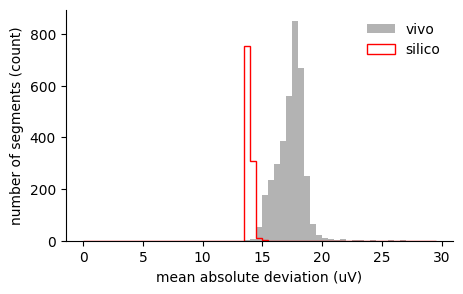

In [13]:
# hist vivo
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(mads_vivo, color=(0.7, 0.7, 0.7), label="vivo", bins=np.arange(0, 30, 0.5))
print("\n in vivo noise (min mean abs. deviation):", min(mads_vivo))

# hist silico
ax.hist(
    mads_fitted_silico,
    edgecolor="r",
    label="silico",
    histtype="step",
    bins=np.arange(0, 30, 0.5),
)
print("\n Fitted in silico noise (min mean abs. deviation):", min(mads_fitted_silico))

# legend
ax.set_ylabel("number of segments (count)")
ax.set_xlabel("mean absolute deviation (uV)")
ax.spines[["right", "top"]].set_visible(False)
ax.legend(frameon=False)

# save figure
plt.savefig("figures/2_realism/2_noise/noise_horv_vs_fitted_model.pdf")
plt.savefig("figures/2_realism/2_noise/noise_horv_vs_fitted_model.svg")

(<Figure size 2000x200 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

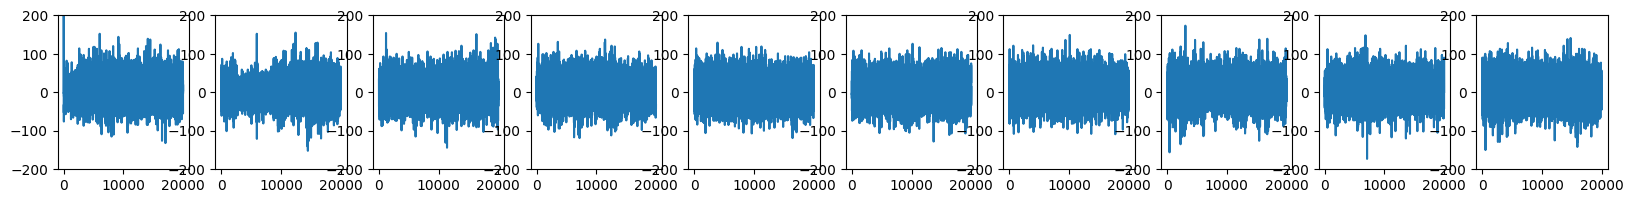

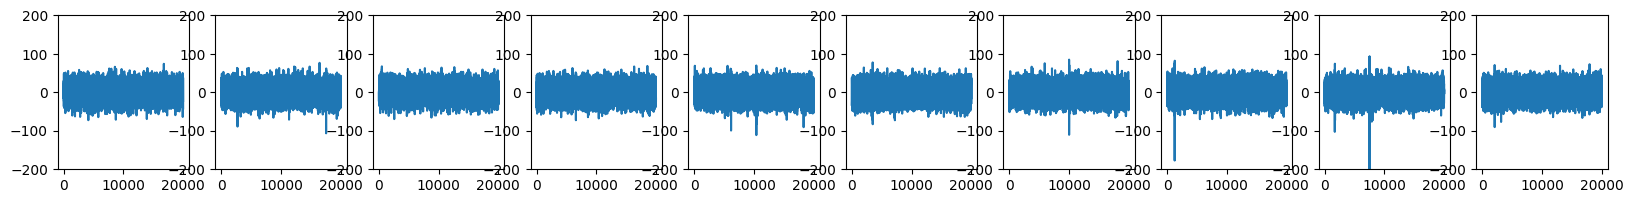

In [14]:
# vivo
plot_example_one_sec_segments(traces_vivo, target_site=0)

# silico
plot_example_one_sec_segments(fitted_traces_silico, target_site=0)